In [1]:
import pandas as pd
import configparser
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', palette='hls')

config = configparser.ConfigParser()
config.read('config.ini')
db_file = config['sqlite']['db_file']
engine = create_engine(f"sqlite:///{db_file}")

In [2]:
student_info = pd.read_sql_table('studentInfo', engine)
student_assessment = pd.read_sql_table('studentAssessment', engine)
student_vle = pd.read_sql_table('studentVle', engine)
courses = pd.read_sql_table('courses', engine)
assessments = pd.read_sql_table('assessments', engine)
vle = pd.read_sql_table('vle', engine)
student_registration = pd.read_sql_table('studentRegistration', engine)

In [ ]:
print("**Formas de las tablas**")
for name, df in [
    ('studentInfo', student_info),
    ('studentAssessment', student_assessment),
    ('studentVle', student_vle),
    ('courses', courses),
    ('assessments', assessments),
    ('vle', vle),
    ('studentRegistration', student_registration),
]:
    print(f"{name}: {df.shape}")
print("\n**Información general de studentInfo**")
print(student_info.info())
print("\n**Estadísticos descriptivos de studentInfo**")
print(student_info.describe(include='all'))

**Formas de las tablas**
studentInfo: (32593, 12)
studentAssessment: (173912, 6)
studentVle: (10655280, 6)
courses: (22, 3)
assessments: (206, 6)
vle: (6364, 6)
studentRegistration: (32593, 5)

**Información general de studentInfo**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  fin

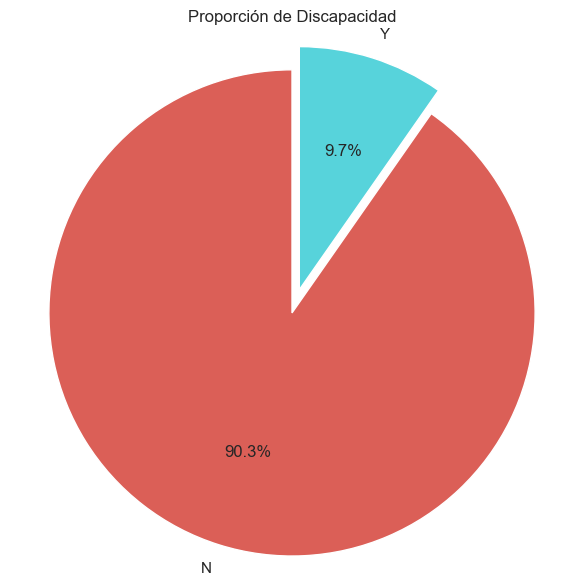

In [5]:
plt.figure(figsize=(6,6))
dis_counts = student_info['disability'].value_counts()
colors = sns.color_palette('hls', len(dis_counts))
explode = [0.0, 0.1] 
plt.pie(dis_counts, labels=dis_counts.index, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=explode, wedgeprops={'edgecolor':'w'})
plt.title('Proporción de Discapacidad')
plt.axis('equal')
plt.tight_layout()
plt.show()

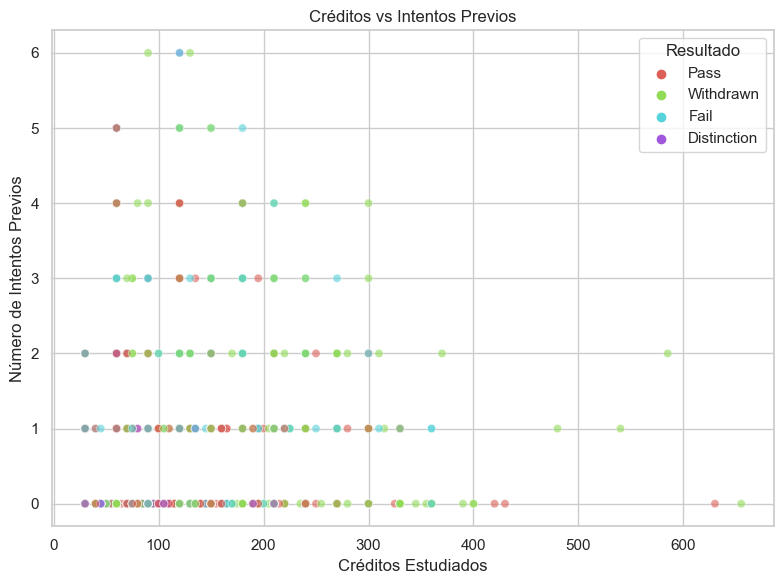

In [9]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x='studied_credits', y='num_of_prev_attempts',
                     hue='final_result', palette='hls',
                     data=student_info, alpha=0.6, edgecolor='w', linewidth=0.5)
ax.set_title('Créditos vs Intentos Previos')
ax.set_xlabel('Créditos Estudiados')
ax.set_ylabel('Número de Intentos Previos')
plt.legend(title='Resultado', loc='upper right')
plt.tight_layout()
plt.show()

<h3><strong></h3></strong>

<p>

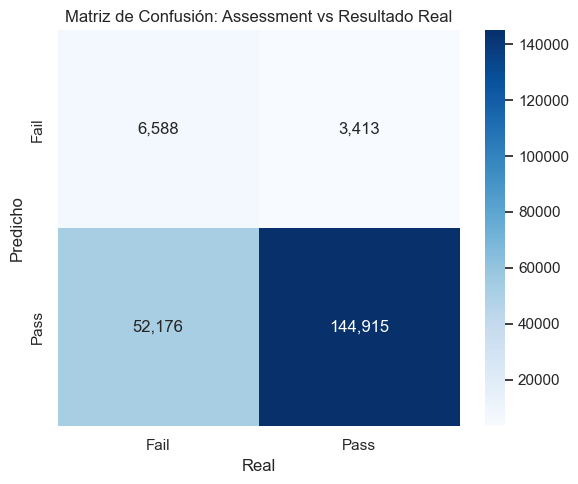

In [11]:
binary_map = {'Pass':'Pass', 'Distinction':'Pass', 'Fail':'Fail', 'Withdrawn':'Fail'}
student_info['actual_binary'] = student_info['final_result'].map(binary_map)

sa = (
    student_assessment
    .merge(
        student_info[['id_student', 'actual_binary']],
        on='id_student',
        how='left'
    )
)

sa = sa.dropna(subset=['assessment_result'])

cm = pd.crosstab(sa['assessment_result'], sa['actual_binary'],
                 rownames=['Predicho'], colnames=['Real'])

labels = cm.applymap(lambda x: f"{x:,}")

plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Matriz de Confusión: Assessment vs Resultado Real')
ax.set_ylabel('Predicho')
ax.set_xlabel('Real')
plt.tight_layout()
plt.show()

<h3><strong></h3></strong>

<p>

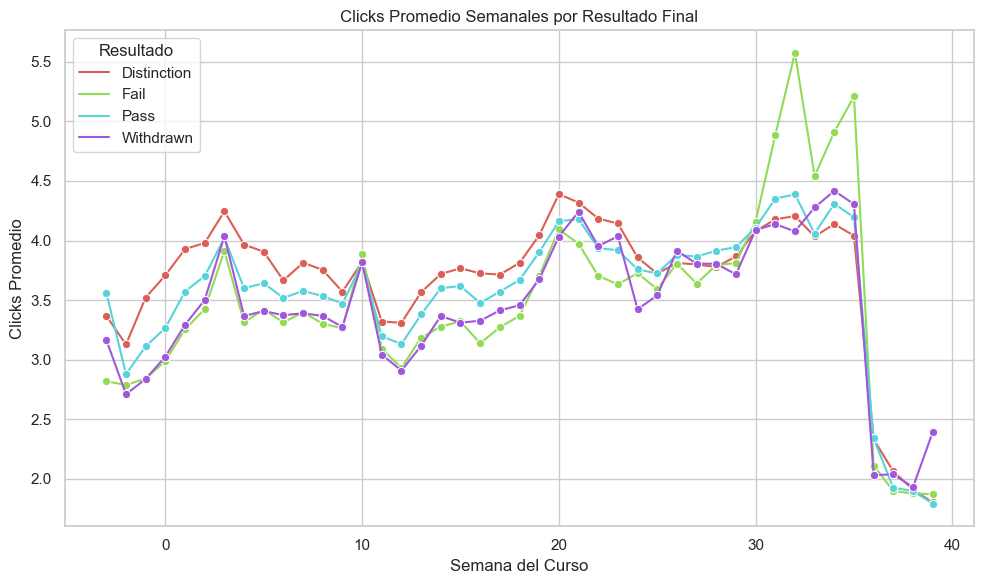

In [19]:
student_vle['week'] = (student_vle['date'] // 7) + 1

merged = student_vle.merge(
    student_info[['id_student', 'final_result']],
    on='id_student',
    how='left'
)

vle_weekly = (
    merged
    .groupby(['week', 'final_result'], as_index=False)['sum_click']
    .mean()
    .rename(columns={'sum_click': 'avg_clicks'})
)

plt.figure(figsize=(10,6))
ax = sns.lineplot(
    x='week',
    y='avg_clicks',
    hue='final_result',
    data=vle_weekly,
    marker='o',
    palette='hls'
)
ax.set_title('Clicks Promedio Semanales por Resultado Final')
ax.set_xlabel('Semana del Curso')
ax.set_ylabel('Clicks Promedio')
plt.legend(title='Resultado', loc='upper left')
plt.tight_layout()
plt.show()

<h3><strong></h3></strong>

<p>

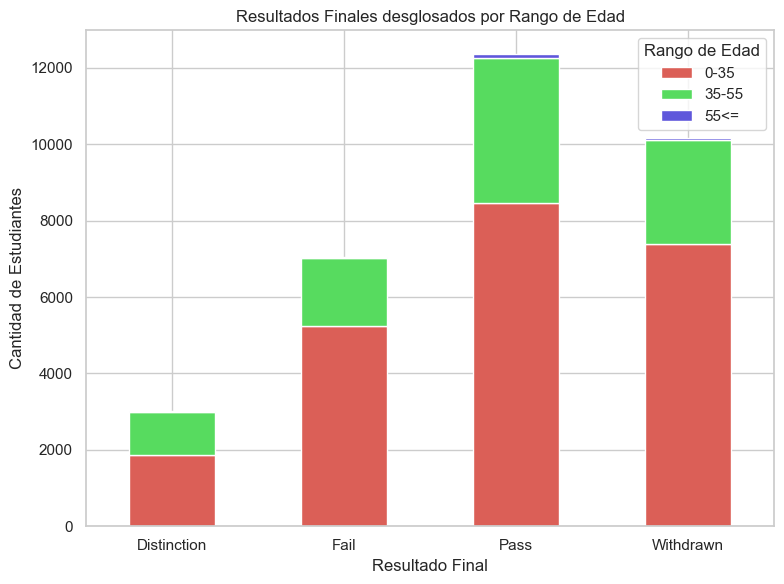

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

ct_age = pd.crosstab(
    student_info['final_result'],
    student_info['age_band']
)[['0-35','35-55','55<=']]  # aseguramos orden de columnas

# Colores con paleta hls
colors_age = sns.color_palette('hls', n_colors=ct_age.shape[1])

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ct_age.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors_age
)
ax.set_title('Resultados Finales desglosados por Rango de Edad')
ax.set_xlabel('Resultado Final')
ax.set_ylabel('Cantidad de Estudiantes')
ax.legend(title='Rango de Edad', loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

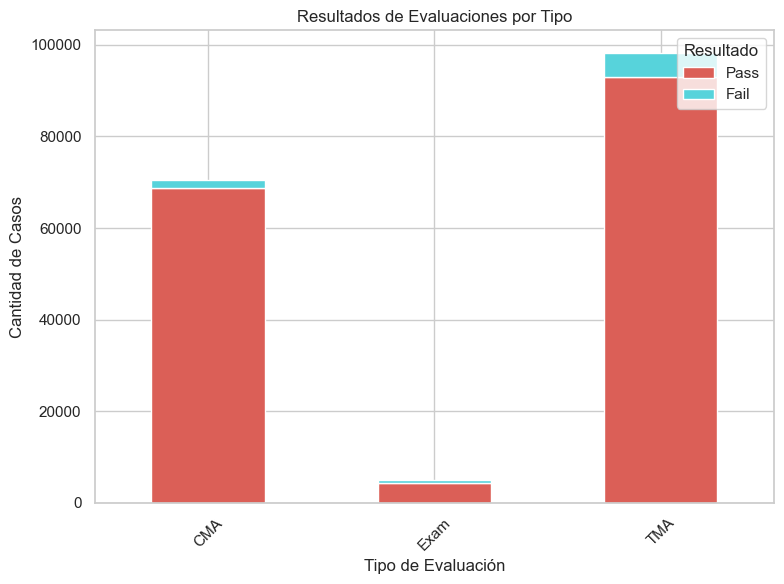

In [ ]:
merged_assess = (
    student_assessment
    .merge(assessments[['id_assessment','assessment_type']],
           on='id_assessment', how='left')
)

ct_assess = pd.crosstab(
    merged_assess['assessment_type'],
    merged_assess['assessment_result']
)[['Pass','Fail']]

colors_res = sns.color_palette('hls', n_colors=2)

fig, ax = plt.subplots(figsize=(8,6))
ct_assess.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors_res
)
ax.set_title('Resultados de Evaluaciones por Tipo')
ax.set_xlabel('Tipo de Evaluación')
ax.set_ylabel('Cantidad de Casos')
ax.legend(title='Resultado', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()